In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Estimación de Insumos en el INT

En este cuadernillo se quieren estimar la cantidad de insumos que necesitará el INT para 2035 considerando su tasa de aumento en cada uno de los diagnósticos más relevantes. Los insumos que se quieren calcular son:

- Camas
- Pabellones
- Procedimientos más importantes (Resonancias, TAC Variadas, Estudios Histopatológicos - Biopsias, etc...)

In [3]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

## Lectura de bases de datos

In [6]:
# Lectura de base DEIS
egresos_torax_deis = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax_deis = egresos_torax_deis[egresos_torax_deis["DIAG1"].isin(DIAGS_RELEVANTES)]
egresos_torax_deis = egresos_torax_deis.drop(
    columns=[
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
)
egresos_torax_deis = egresos_torax_deis.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_deis["dias_en_anio"] = egresos_torax_deis["ANO_EGRESO"].apply(
    build_features.days_in_year
)

# Lectura de base GRD
egresos_torax_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")
egresos_torax_grd = egresos_torax_grd.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_grd["dias_en_anio"] = egresos_torax_grd["ANO_EGRESO"].apply(
    build_features.days_in_year
)

## Estimación de Cantidad de Camas

Para estimar la cantidad de camas necesarias se utilizarán los días de estada necesarios para
cada uno de los diagnósticos. Además, se obtendrán los días para cada uno de los años analizados. La fórmula para calcular la cantidad de camas es:

$Cantidad De Camas = \frac{Dias Estada En Periodo}{Cantidad Dias Periodo}$

Por ejemplo:

Si un diangóstico X tiene 2450 Días de Estada en 1 año (no bisiesto), entonces se necesitan la siguiente cantidad de camas para suplir tal diagnóstico:

$Cantidad De Camas = \frac{2450}{365} = 6.7 Camas$

In [8]:
egresos_torax_deis["camas_necesarias"] = (
    egresos_torax_deis["dias_estada_totales"] / egresos_torax_deis["dias_en_anio"]
)
egresos_torax_grd["camas_necesarias"] = (
    egresos_torax_grd["dias_estada"] / egresos_torax_grd["dias_en_anio"]
)

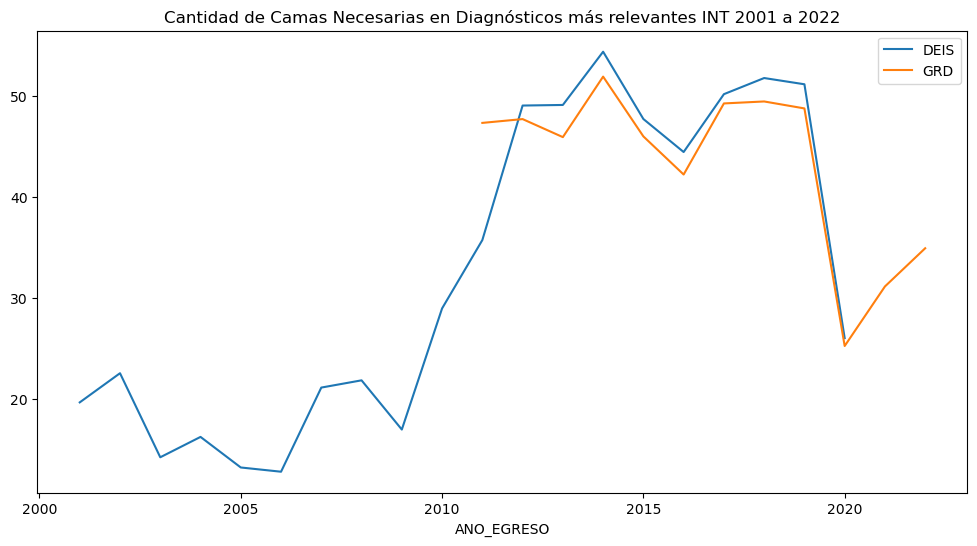

In [20]:
cantidad_camas_deis = egresos_torax_deis.groupby("ANO_EGRESO")["camas_necesarias"].sum()
cantidad_camas_grd = egresos_torax_grd.groupby("ANO_EGRESO")["camas_necesarias"].sum()

fig, axis = plt.subplots()
cantidad_camas_deis.plot(ax=axis, label="DEIS")
cantidad_camas_grd.plot(ax=axis, label="GRD")
plt.legend()
plt.title("Cantidad de Camas Necesarias en Diagnósticos más relevantes INT 2001 a 2022")
plt.show()